In this notebook we will work through a first-level model using the GLM tools within nipy.  These are not as widely used as the FSL tools, but they run much faster and afford us some more flexibility.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nibabel as nib
print "nibabel:", nib.__version__
import nipy
print "nipy:", nipy.__version__

nibabel: 2.0.0
nipy: 0.3.0


In [3]:
img = nib.load('srabold.nii.gz')

In [4]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [  4  40  64  64 121   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 68.25
qoffset_y       : -118.125
qoffset_z       : -118.125
srow_x          : [ -3.5    0.   

Defaults for plotting

In [5]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

Loading the image may take a little while:

In [6]:
data = img.get_data()
data.shape

(40, 64, 64, 121)

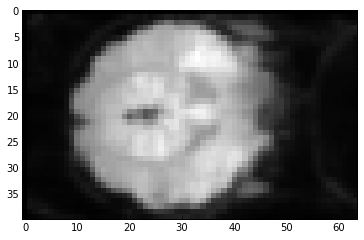

In [7]:
plt.imshow(data.mean(axis=-1)[:, :, 30])

Why is this image blurry?

So what was the subject doing here?

https://openfmri.org/dataset/ds000105

* 001 House
* 002 Scrambled
* 003 Cat
* 004 Shoe
* 005 Bottle
* 006 Scissors
* 007 Chair
* 008 Face

In [8]:
event_types = ['house', 'scrambled', 'cat', 'shoe', 'bottle', 'scissors', 'chair', 'face']

You should have the task lists for this subject in your `~/data/ds105` directory.  Let's check:

In [9]:
import os
from os import path as osp
HOME = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME, 'data', 'ds105')
SUB1_TASK_PATH = os.path.join(DATA_PATH, 'sub001', 'model', 'model001', 'onsets', 'task001_run001')
os.path.isdir(SUB1_TASK_PATH)

True

If you got "False" above - you can download the zip file of the task files you need from:

http://nipy.bic.berkeley.edu/practical_neuroimaging/ds105_sub001_tasks.zip

Download the file, then `cd ~/data` and `unzip ~/Downloads/ds105_sub001_tasks.zip` (if you downloaded the file to your `Downloads` folder.

Recheck:

In [10]:
os.path.isdir(SUB1_TASK_PATH)

True

Look in this path:

In [11]:
os.listdir(SUB1_TASK_PATH)

['cond001.txt',
 'cond008.txt',
 'cond005.txt',
 'cond006.txt',
 'cond007.txt',
 'cond003.txt',
 'cond004.txt',
 'cond002.txt']

What are in these files?

In [12]:
COND1_FNAME = os.path.join(SUB1_TASK_PATH, 'cond001.txt')
print(open(COND1_FNAME, 'rt').read())

156.000	0.5	1
158.000	0.5	1
160.000	0.5	1
162.000	0.5	1
164.000	0.5	1
166.000	0.5	1
168.000	0.5	1
170.000	0.5	1
172.000	0.5	1
174.000	0.5	1
176.000	0.5	1
178.000	0.5	1



This is a common format for specifying events - any guesses what the columns are?


We can actually do :

In [13]:
dtype_def = [('onset', 'f'), ('duration', 'f'), ('amplitude', 'f')]
evs = np.loadtxt(COND1_FNAME, dtype_def)
evs

array([(156.0, 0.5, 1.0), (158.0, 0.5, 1.0), (160.0, 0.5, 1.0),
       (162.0, 0.5, 1.0), (164.0, 0.5, 1.0), (166.0, 0.5, 1.0),
       (168.0, 0.5, 1.0), (170.0, 0.5, 1.0), (172.0, 0.5, 1.0),
       (174.0, 0.5, 1.0), (176.0, 0.5, 1.0), (178.0, 0.5, 1.0)], 
      dtype=[('onset', '<f4'), ('duration', '<f4'), ('amplitude', '<f4')])

This is nice because:

In [14]:
evs[0]['onset']

156.0

In [15]:
evs['onset']

array([ 156.,  158.,  160.,  162.,  164.,  166.,  168.,  170.,  172.,
        174.,  176.,  178.], dtype=float32)

We can load our events for all types:

In [16]:
# create event_defs : a dictionary with keys the type of events, ('bottle', 'cat', ..)
event_defs = {}
for eno in range(8):
    fname = os.path.join(os.path.join(SUB1_TASK_PATH, 'cond%03d.txt' % (eno + 1)))
    print(fname)
    event_name = event_types[eno]
    event_defs[event_name] = np.loadtxt(fname, dtype_def)
event_defs          

/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond001.txt
/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond002.txt
/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond003.txt
/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond004.txt
/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond005.txt
/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond006.txt
/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond007.txt
/home/jb/data/ds105/sub001/model/model001/onsets/task001_run001/cond008.txt


{'bottle': array([(228.0, 0.5, 1.0), (230.0, 0.5, 1.0), (232.0, 0.5, 1.0),
        (234.0, 0.5, 1.0), (236.0, 0.5, 1.0), (238.0, 0.5, 1.0),
        (240.0, 0.5, 1.0), (242.0, 0.5, 1.0), (244.0, 0.5, 1.0),
        (246.0, 0.5, 1.0), (248.0, 0.5, 1.0), (250.0, 0.5, 1.0)], 
       dtype=[('onset', '<f4'), ('duration', '<f4'), ('amplitude', '<f4')]),
 'cat': array([(84.0, 0.5, 1.0), (86.0, 0.5, 1.0), (88.0, 0.5, 1.0),
        (90.0, 0.5, 1.0), (92.0, 0.5, 1.0), (94.0, 0.5, 1.0),
        (96.0, 0.5, 1.0), (98.0, 0.5, 1.0), (100.0, 0.5, 1.0),
        (102.0, 0.5, 1.0), (104.0, 0.5, 1.0), (106.0, 0.5, 1.0)], 
       dtype=[('onset', '<f4'), ('duration', '<f4'), ('amplitude', '<f4')]),
 'chair': array([(264.0, 0.5, 1.0), (266.0, 0.5, 1.0), (268.0, 0.5, 1.0),
        (270.0, 0.5, 1.0), (272.0, 0.5, 1.0), (274.0, 0.5, 1.0),
        (276.0, 0.5, 1.0), (278.0, 0.5, 1.0), (280.0, 0.5, 1.0),
        (282.0, 0.5, 1.0), (284.0, 0.5, 1.0), (286.0, 0.5, 1.0)], 
       dtype=[('onset', '<f4'), ('duration

Are these onsets in TRs or in seconds?

OK - how to make our design?

In [34]:
# use to be : import nipy.modalities.fmri.design as fmrid #
from nipy.modalities.fmri.experimental_paradigm import EventRelatedParadigm
import nipy.modalities.fmri.design_matrix as dm

#from glob import glob

EventRelatedParadigm takes a list of string and events

In [23]:
n_scans = img.shape[-1]
TR = 2.5
t = np.arange(n_trs) * TR

In [24]:
print(event_defs.keys())
print(event_defs['house']['onset'])

['house', 'cat', 'scrambled', 'shoe', 'bottle', 'scissors', 'chair', 'face']
[ 156.  158.  160.  162.  164.  166.  168.  170.  172.  174.  176.  178.]


In [25]:
conditions = []
onsets = []

for cond in event_defs.keys():
    cond_onsets = event_defs[cond]['onset']
    conditions += [cond]*len(cond_onsets)
    onsets += list(cond_onsets)

print(conditions)
print(onsets)

['house', 'house', 'house', 'house', 'house', 'house', 'house', 'house', 'house', 'house', 'house', 'house', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'scissors', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face']
[156.0, 158.0, 160.0, 162.0, 164.0, 166.0, 168.0, 170.0, 172.0, 174.0, 176.0, 178.0, 84

In [32]:
# make paradigm with conditions and onsets (you could add durations and magnitude here)
paradigm = EventRelatedParadigm(conditions, onsets)

hrf_model = 'canonical'
drift_model = 'cosine'
# here you would pick the motion regressors
motion_reg = np.cumsum(np.random.randn(n_scans, 6), 0)
motion_reg_names = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']
frametimes = np.linspace(0, (n_scans - 1) * TR, n_scans)

Nice - so let's make the design:

In [35]:
X, names = dm.dmtx_light(frametimes, paradigm, drift_model='cosine',
                         hfcut=128, hrf_model=hrf_model, add_regs=motion_reg,
                         add_reg_names=motion_reg_names)


/home/jb/.virtualenvs/py2/local/lib/python2.7/site-packages/nipy/modalities/fmri/design_matrix.py:186: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if rmatrix == None:


/home/jb/.virtualenvs/py2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


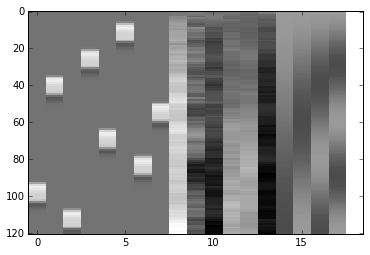

In [42]:
plt.imshow(X/X.std(axis=0), interpolation='nearest', aspect='auto')

In [48]:
from nipy.modalities.fmri.glm import GeneralLinearModel


sh = img.shape[:-1]
Y = img.get_data().reshape(np.prod(sh), n_scans)
glm = GeneralLinearModel(X)
glm.fit(Y.T)


In [55]:
# specify the contrast [1 -1 0 ..]
contrast = np.zeros(X.shape[1])
contrast[:8] = [-1, -1, -1, -1, -1, -1, -1, 7]


In [56]:
# compute the constrast image related to it
zvals = glm.contrast(contrast).z_score()
contrast_image = nib.Nifti1Image(np.reshape(zvals, sh), img.get_affine())


In [57]:
con_img = np.reshape(contrast_image.get_data(), img.shape[:-1])
con_img.shape

(40, 64, 64)

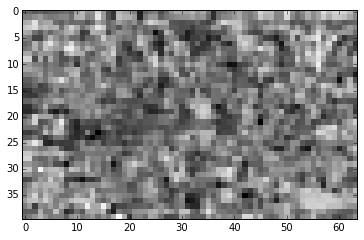

In [58]:
plt.imshow(con_img[..., 30])

Can you find any face activity you believe?